In [1]:
from datasets import load_dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import pandas as pd

/home/sina/miniconda3/envs/hugface/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Exploring and visualizing MNIST

In [2]:
dataset = load_dataset("mnist")
dataset.set_format('numpy')

In [4]:
img1d = np.array([dataset['train'][i]['image'].flatten() for i in range(len(dataset['train']))])
labels= dataset['train']['label']
img_shape= dataset['train'][0]['image'].shape
img_shape

(28, 28)

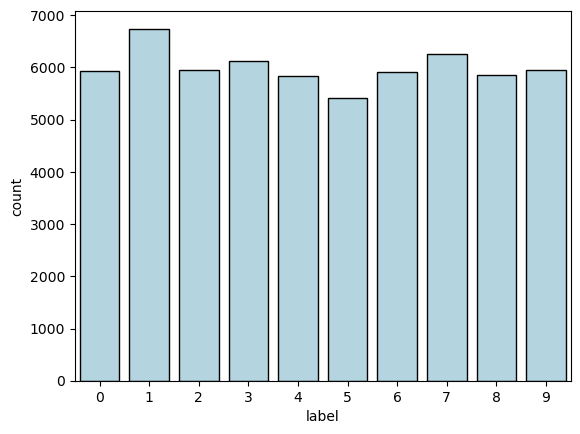

In [4]:
sns.countplot(x=labels,linewidth=1,edgecolor='black',color='lightblue')
_ = plt.xlabel('label')

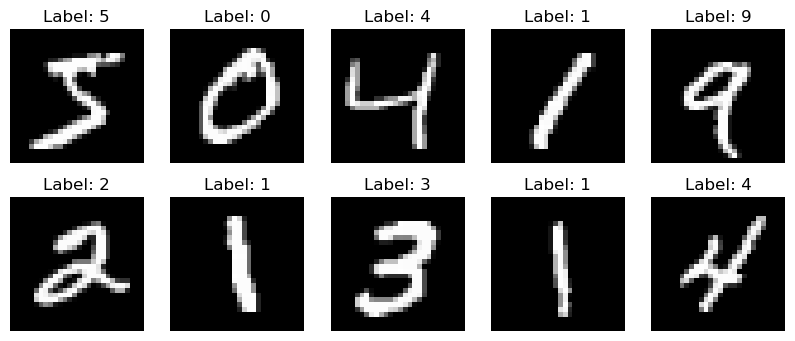

In [5]:
import matplotlib.pyplot as plt
# Visualizing the first few images in the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(dataset['train'][i]['image'], cmap='gray')
    plt.title(f"Label: {dataset['train'][i]['label']}")
    plt.axis('off')

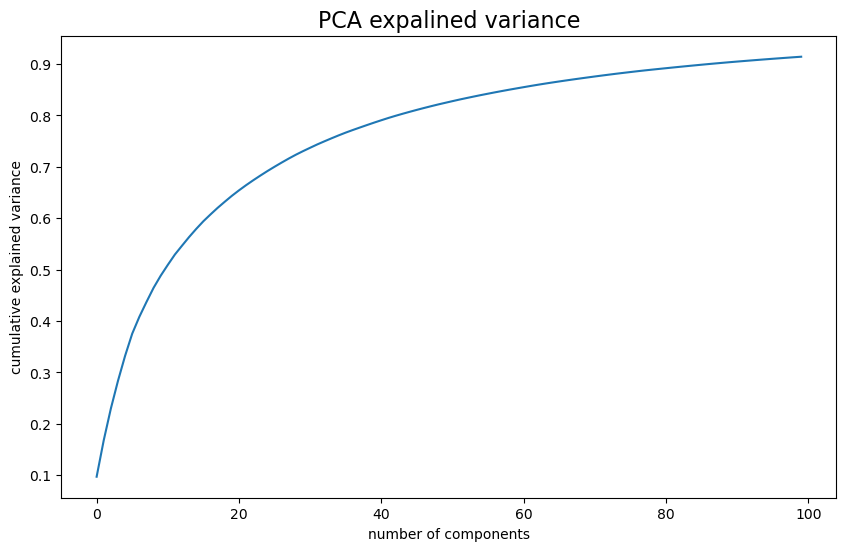

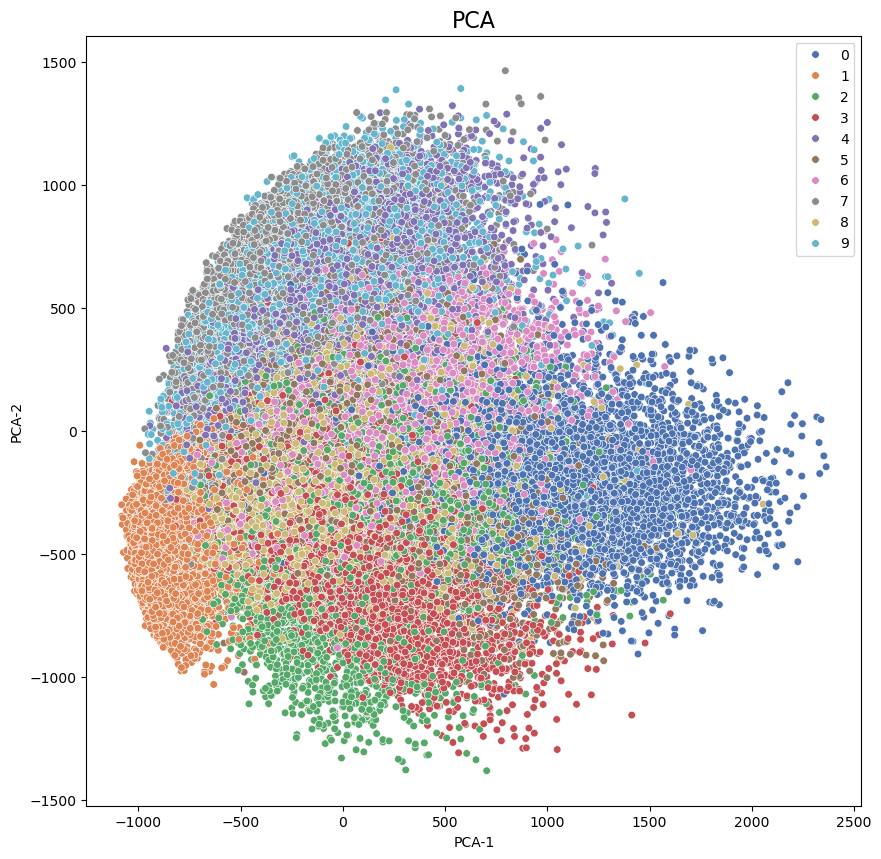

In [22]:
pca_data = pd.DataFrame()
pca = PCA(n_components=100)
img2d = pca.fit_transform(img1d)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA explained variance',fontsize = 16)
plt.savefig('pca_ratio.png',dpi = 400)


pca_data['PCA-1'] = img2d[:, 0]
pca_data['PCA-2'] = img2d[:, 1]
pca_data['label'] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(pca_data,x='PCA-1',y = 'PCA-2', hue=labels,legend=True,s = 30,palette="deep")
plt.title('PCA',fontsize = 16)
plt.savefig('pca.png',dpi = 400)

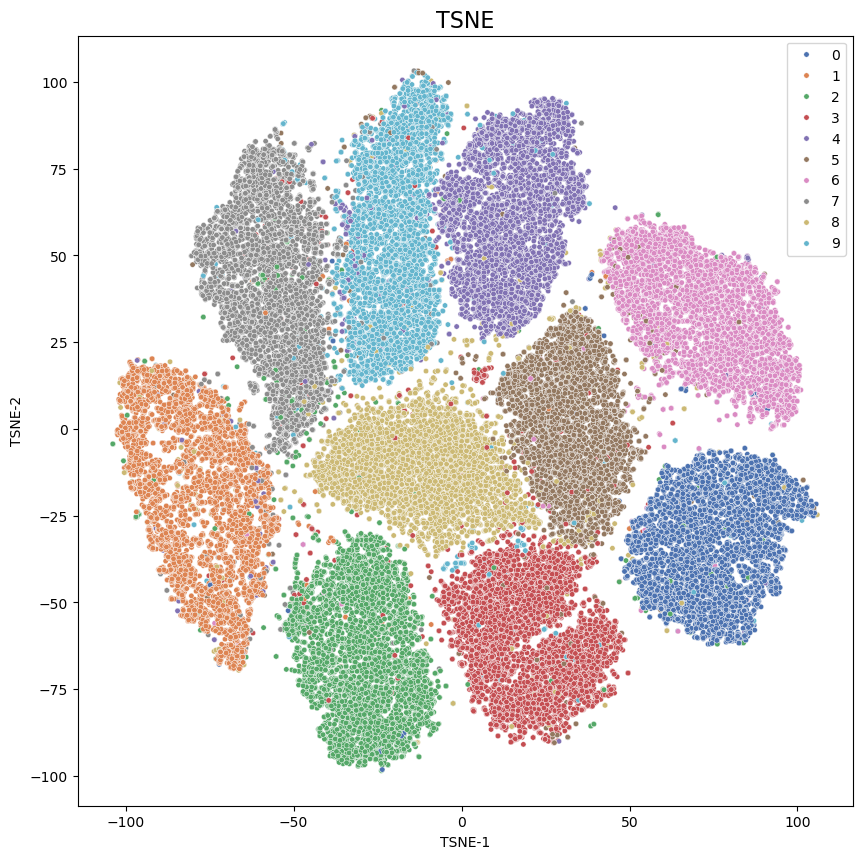

In [40]:
tsne_data = pd.DataFrame()
tsne = TSNE(n_components=2)
img2d = tsne.fit_transform(img1d)
tsne_data['TSNE-1'] = img2d[:, 0]
tsne_data['TSNE-2'] = img2d[:, 1]
tsne_data['label'] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(tsne_data,x='TSNE-1',y = 'TSNE-2', hue=labels,legend=True,s = 15,palette="deep")
plt.title('TSNE',fontsize = 16)
plt.savefig('tsne.png',dpi = 400)

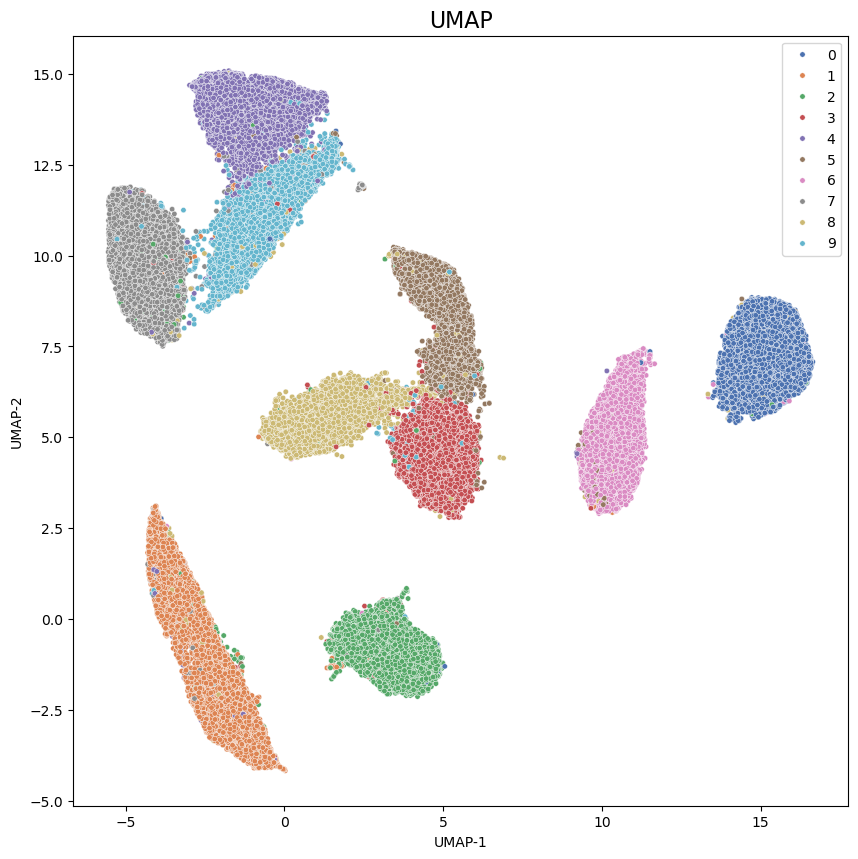

In [42]:
umap = UMAP(n_components=2)
img2d = umap.fit_transform(img1d)
umap_data = pd.DataFrame()
umap_data['UMAP-1'] = img2d[:, 0]
umap_data['UMAP-2'] = img2d[:, 1]
umap_data['label'] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(umap_data, x='UMAP-1',y = 'UMAP-2', hue=labels, legend=True, s = 15, palette="deep")
plt.title('UMAP',fontsize = 16)
plt.savefig('umap.png',dpi = 400)

## Projecting data into pre-defined programs

The goal here is to sanity-check our method for projecting our high-dimensial data into linear combination of pre-defined "programs". We want to use MNIST dataset to see if the training method is able to come up with a correct mapping to the programs that correspond to each of the 10 digits. The programs are defined as average of the images labeled with each of the digits. 

optionally, we also want to see if we can get a decent reconstruction of the original space from projections
here we define the program for each digit to be the average of the images in that digit

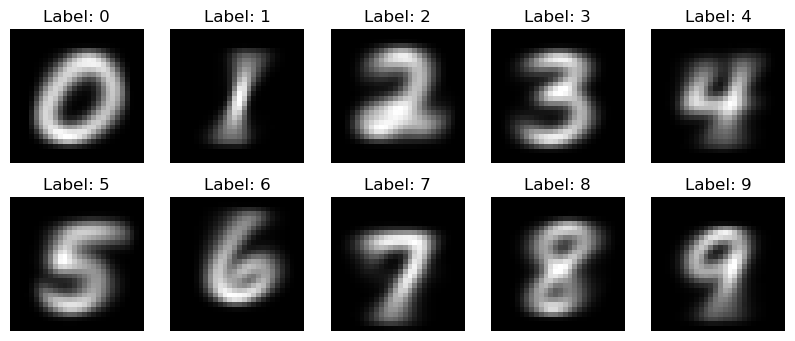

In [5]:
# for each digit, we will plot the average of pixels from the images belonging to that digit
imgs_grouped_by_label = [dataset['train']['image'][labels == i] for i in range(10)]
avg_img = [imgs_grouped_by_label[i].mean(axis=0) for i in range(10)]
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(avg_img[i], cmap='gray')
    plt.title(f"Label: {i}")
    plt.axis('off')


digit_programs = [avg_img[i].flatten() for i in range(10)]

In [ ]:
from models import geneprog_encoder_linear, geneprog_encoder_MLP
from gene_programs import train_and_encode_for_mnist
from datetime import datetime

datetimestamp = datetime.now().strftime('%Y_%m_%d___%H_%M_%S')
gp_encoder_model = geneprog_encoder_MLP
run_name = f"{gp_encoder_model.__name__}_{datetimestamp}"

X_program_scores , X_reconst = train_and_encode_for_mnist(

    encoder_model=gp_encoder_model,
    X = img1d,
    program_def = digit_programs,
    tru_labels = labels,
    WANDB_LOGGING = True,
    LEARNING_RATE = 0.0005,
    WEIGHT_DECAY = 1e-5,
    N_EPOCHS = 250,
    BATCH_SIZE = 100,
    OUTPUT_PREFIX = "./gene_program_runs",
    RUN_NAME = run_name,

)


----

### visualizing reconstruction examples

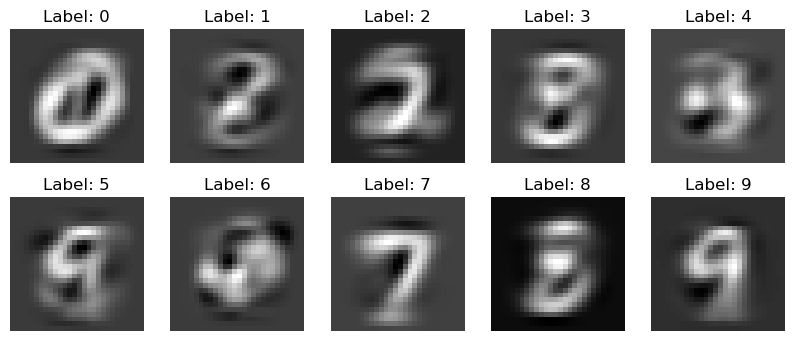

In [16]:

idxs = np.arange(len(X_program_scores))
idx_grouped_by_label = [idxs[labels == i] for i in range(10)]

sel_idxs = [idx_grouped_by_label[i][np.random.randint(0, len(idx_grouped_by_label[i]))] for i in range(10)]
example_reconst = [X_reconst[sel_idxs[i]].reshape(img_shape) for i in range(10)]

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_reconst[i], cmap='gray')
    plt.title(f"Label: {i}")
    plt.axis('off')

----

### visualizing program scores using dimensionality reduction

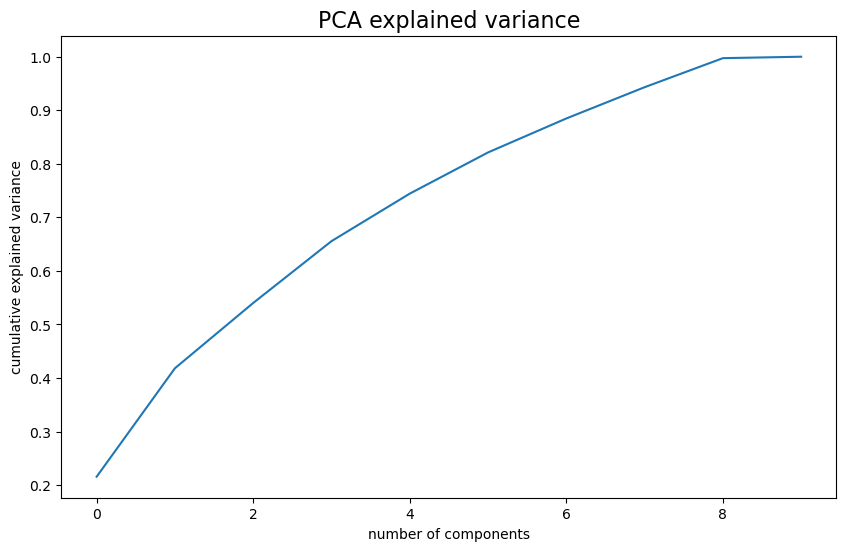

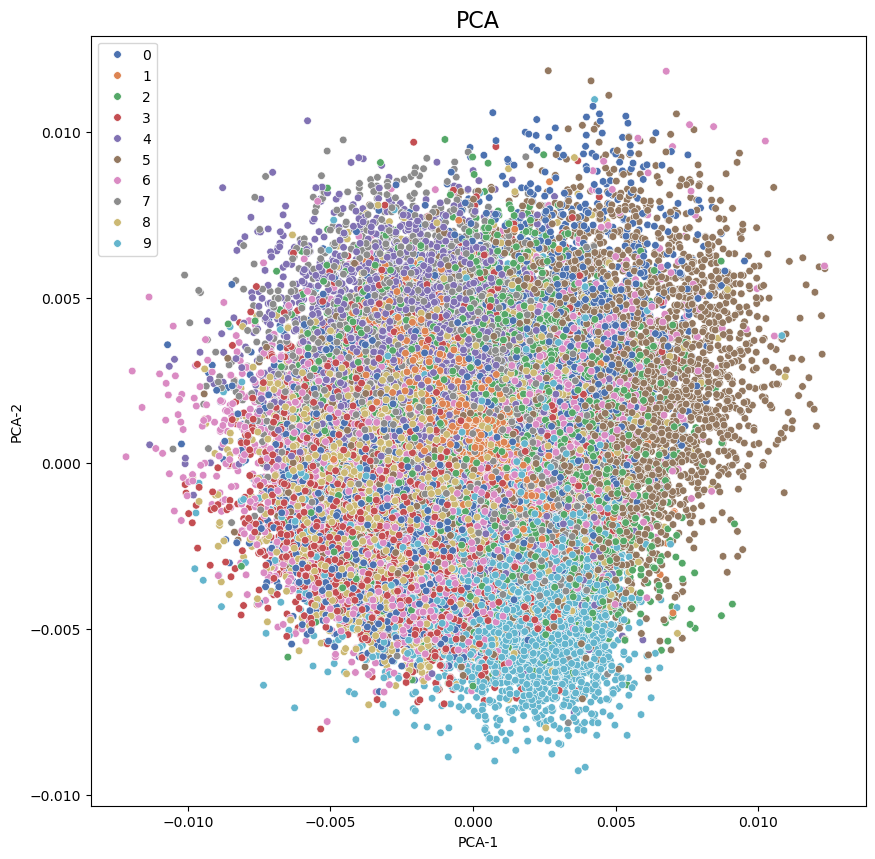

In [17]:
pca_data_gp = pd.DataFrame()
pca = PCA()
ps2d = pca.fit_transform(X_program_scores)
# plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA explained variance',fontsize = 16)
plt.savefig('pca_ratio.png',dpi = 400)

pca_data_gp['PCA-1'] = ps2d[:, 0]
pca_data_gp['PCA-2'] = ps2d[:, 1]
pca_data_gp['label'] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(pca_data_gp, x='PCA-1',y = 'PCA-2', hue=labels,legend=True,s = 30,palette="deep")
plt.title('PCA',fontsize = 16)
plt.savefig('pca.png',dpi = 400)

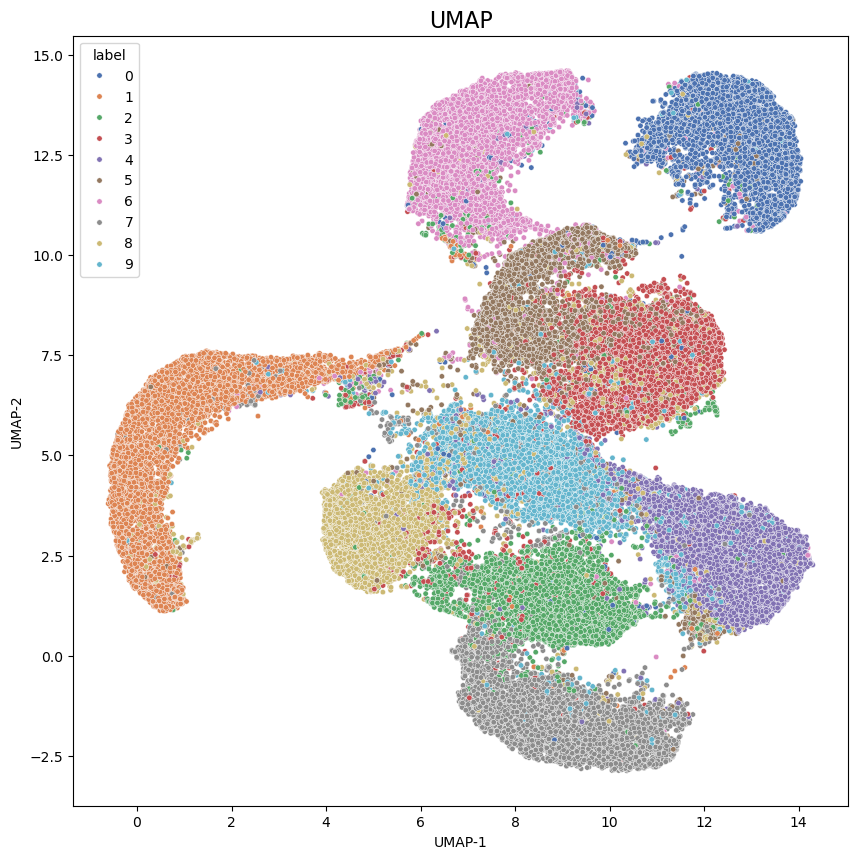

In [18]:
umap = UMAP(n_components=2)
ps2d = umap.fit_transform(X_program_scores)
umap_data_gp = pd.DataFrame()
umap_data_gp['UMAP-1'] = ps2d[:, 0]
umap_data_gp['UMAP-2'] = ps2d[:, 1]
umap_data_gp['label'] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(umap_data_gp, x='UMAP-1',y = 'UMAP-2', hue='label', legend=True, s = 15, palette="deep")
plt.title('UMAP',fontsize = 16)
plt.savefig('umap.png',dpi = 400)

----

### Heatmap to show the assigned program scores for examples of each label

in the heatmap, rows are examples (grouped by their label), and columns are programs (0...9), and color shows their assigned program scores. 

Examples are grouped by their labels so all zero-labeled examples are at the first rows of the heatmap and after those we have 1-labeled examples and so on. So I was expecting to see a clear difference between examples with different labels

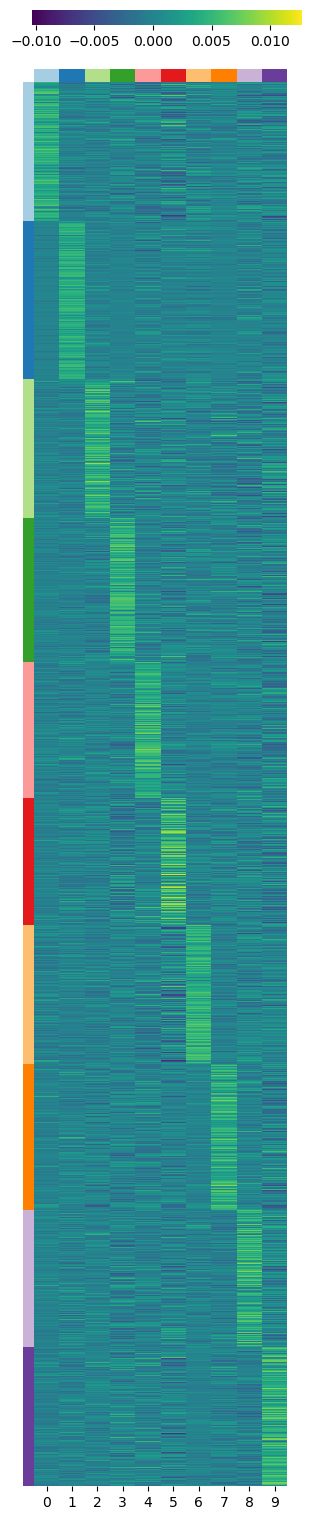

In [19]:
import matplotlib.cm as cm
sort_idx = np.argsort(labels)
sorted_program_scores = X_program_scores[sort_idx,:]
sorted_labels = labels[sort_idx]
# fig, ax = plt.subplots(figsize=(3,20))


colormap = cm.get_cmap('Paired')
colc = [colormap(i) for i in range(10)]
colc_map = {i:colc[i] for i in range(10)}
rowc = pd.Series(sorted_labels).map(colc_map).to_numpy()



_ =sns.clustermap(sorted_program_scores,yticklabels=False,xticklabels=True,cmap='viridis',row_cluster = False,col_cluster = False,figsize=(3,15),row_colors=rowc,col_colors=colc,colors_ratio=(0.04,0.009),cbar_pos=(0.1,1,0.9,0.01),cbar_kws={'orientation':'horizontal'},dendrogram_ratio=0.02)


#### relationship between label and program with highest score

In [20]:
top_programs = np.argmax(sorted_program_scores, axis=1)

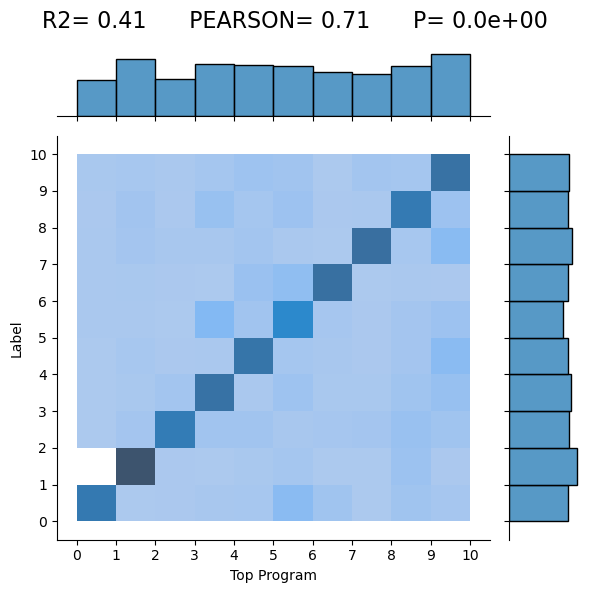

In [21]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
# fig, ax = plt.subplots(figsize=(5, 5))
# sns.distplot(x=top_programs,y=sorted_labels, gridsize = 12)

# ax.hexbin(x=top_programs,y=sorted_labels, gridsize = 12)
sns.jointplot(x=top_programs,y=sorted_labels,kind='hist',bins = (np.arange(11),np.arange(11)),marginal_kws=dict(bins = np.arange(11)))
plt.xlabel('Top Program')
plt.ylabel('Label')
plt.xticks(np.arange(11))
plt.yticks(np.arange(11))
pearson_res= pearsonr(top_programs,sorted_labels)
r_squared = r2_score(top_programs,sorted_labels)
_ = plt.suptitle(f'R2= {r_squared:.2f}      PEARSON= {pearson_res[0]:.2f}      P= {pearson_res[1]:.1e}',fontsize = 16)
plt.tight_layout()